本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

### 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from matplotlib.colors import cnames
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections


数据集加载：去掉含有空值的数据。

In [4]:
def load_data(path='..\data\[UCI] AAAI-14 Accepted Papers - Papers.csv'):
    df_data = pd.read_csv(path)
    df_data = df_data.dropna()
    return df_data

df = load_data()
df.describe() 


,title,authors,groups,keywords,topics,abstract
count,392,392,392,392,392,392
unique,392,387,125,392,348,392
top,Learning Low-Rank Representations with Classwi...,Chen Chen and Vincent Ng,Novel Machine Learning Algorithms (NMLA),Community detection\nGraph clustering\nGraph d...,GTEP: Social Choice / Voting,Most work building on the Stackelberg security...
freq,1,2,49,1,7,1


特征提取：
- 因为聚类算法对噪点较敏感，考虑到group/topic的不客观性，将它们作为评价指标而不是特征是一种更好的选择。
- 使用词袋模型对每个特征进行抽象。

In [6]:
# 去除不客观的特征
df_fea = df.drop(['groups', 'topics'],axis=1)

cv = CountVectorizer(min_df=0.0, max_df=1.0)
X_fea = [[i] for i in range(df.shape[0])]
for col in df_fea.columns:
    tmp = cv.fit_transform(df_fea[col])
    # 每个feature是【样本数×词袋大小】的
    feature = tmp.toarray()
    X_fea = np.concatenate((X_fea, feature), axis=1)

X_fea.shape

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   0,   0, ...,   0,   0,   0],
       [  2,   0,   0, ...,   0,   0,   0],
       ...,
       [389,   0,   0, ...,   0,   0,   0],
       [390,   0,   0, ...,   0,   0,   0],
       [391,   0,   0, ...,   0,   0,   0]], dtype=int64)

聚类的评估方法有以下两种：
- SC系数：针对单个样本而言。结合了聚类的凝聚度（Cohesion）和分离度（Separation），用于评估聚类的效果。
- CH系数：针对整体结果而言。类别内部数据的协方差越小越好，类别之间的协方差越大越好。

这里通过计算得分方法，参照评价指标（'keywords', 'groups', 'topics'），返回SC系数和CH系数。

In [4]:
# 取出最能代表文章主题的三个特征作为后面的评价指标
df_cls = df[['keywords', 'groups', 'topics']]
cv = CountVectorizer(min_df=0.2, max_df=1.0)
X_cls = [[i] for i in range(df.shape[0])]
for col in df_cls.columns:
    tmp = cv.fit_transform(df_cls[col])
    feature = tmp.toarray()
    X_cls = np.concatenate((X_cls, feature), axis=1)

def cal_score(result_list):
    global X_cls
    sh = silhouette_score(X_cls, result_list)
    ch = calinski_harabasz_score(X_cls, result_list)
    return sh,ch


降维：
- PCA：通过矩阵运算的方法提取最主要的特征，节省效率。
- t-SNE：t-Distributed Stochastic Neighbor Embedding是一种降维技术，用于在二维或三维的低维空间中表示高维数据集，从而使其可视化。与其他降维算法(如PCA)相比，t-SNE创建了一个缩小的特征空间，相似的样本由附近的点建模，不相似的样本由高概率的远点建模。便于可视化。

这里使用PCA提取主成分进行降维，对降维后的数据进行聚类，遍历获得表现最好的n_components和k值。

In [5]:
rec = collections.defaultdict(list)
for _cmp in [2, 5, 10, 50, 100]:
    X_pca = PCA(n_components=_cmp).fit_transform(X_fea)
    print(X_pca.shape)
    for _k in range(5, 16):
        model = KMeans(n_clusters=_k)
        res = model.fit_predict(X_pca)
        sh,ch = cal_score(res)
        print('k:',_k, 'sh:', sh, 'ch:', ch, 'score:', sh*ch)
        rec[_cmp].append(sh*ch)


(392, 2)
k: 5 sh: 0.5478712999412111 ch: 2287.742371629651 score: 1253.3883870753261
k: 6 sh: 0.5368258953851707 ch: 2645.1587919239505 score: 1419.989736910531
k: 7 sh: 0.5278357569962739 ch: 2992.9492542389025 score: 1579.7856352626247
k: 8 sh: 0.5195710602057096 ch: 3327.143637313055 score: 1728.687547095425
k: 9 sh: 0.512250312677174 ch: 3639.886321930314 score: 1864.5329065181722
k: 10 sh: 0.5050676973059094 ch: 3958.8891396499357 score: 1999.507021652366
k: 11 sh: 0.49914366118535947 ch: 4251.255294684053 score: 2121.9871324222427
k: 12 sh: 0.49191215499742835 ch: 4549.344645421493 score: 2237.877928355298
k: 13 sh: 0.4869146646177637 ch: 4815.040000952501 score: 2344.513587184904
k: 14 sh: 0.47938969900166184 ch: 5067.132308077214 score: 2429.1310319707313
k: 15 sh: 0.47298444084305397 ch: 5240.433617547639 score: 2478.643564370913
(392, 5)
k: 5 sh: 0.5481846758073398 ch: 2288.1708261055273 score: 1254.3401825004712
k: 6 sh: 0.5373779899032458 ch: 2645.2109489855197 score: 1421.

将以上结果可视化。

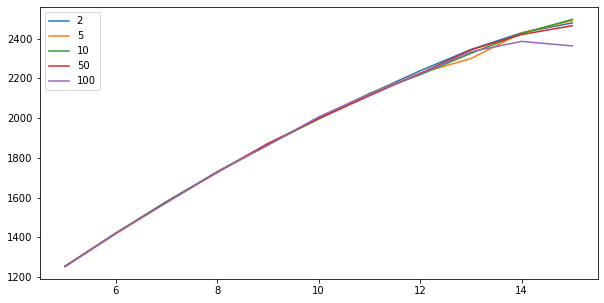

In [6]:
fig = plt.figure(figsize=(10, 5))
x = [_ for _ in range(5,16)]
for _k in rec:
    plt.plot(x,rec[_k],label=_k)
plt.legend()

发现主成分的个数对聚类效果影响不大，提取特征为5维，聚类为15类时，效果较好。

In [77]:
X_pca = PCA(n_components=5).fit_transform(X_fea)
model = KMeans(n_clusters=15)
res = model.fit_predict(X_pca)


下面通过映射至3维，直观展示聚类效果。分别使用PCA和TSNE两种方法。

In [78]:
X_pca = PCA(n_components=3).fit_transform(X_pca)
X_pca = np.hstack((X_pca, [[r] for r in res]))
X_tsne = TSNE(n_components=3).fit_transform(X_pca)
X_tsne = np.hstack((X_tsne, [[r] for r in res]))


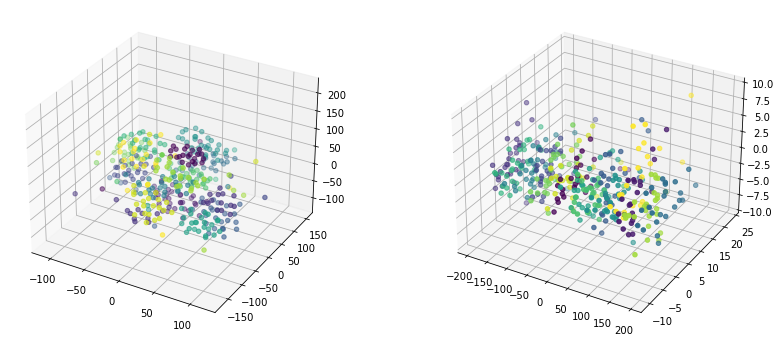

In [79]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=X_tsne[:, 3])
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:,2],c =X_pca[:,3])
plt.show()
